## Objetivo específico do trabalho: analisar a base construída com dados de jogos esportivos ao vivo e prever um evento específico e isolado por meio de automl e redes neurais com bons resultados

# Load and imports

In [80]:
import pandas as pd

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

df05ht = pd.read_csv('data_live_scores_full.csv', encoding='utf-8')
print(df05ht.shape)

(1583326, 37)


In [81]:
df05ht.columns

Index(['date', 'minute', 'homeTeam', 'awayTeam', 'goalHome', 'goalAway',
       'shotsHome', 'shotsAway', 'crossesHome', 'crossesAway', 'assistsHome',
       'assistsAway', 'blockedShotsHome', 'blockedShotsAway', 'league',
       'corners_home', 'corners_away', 'redcards_home', 'redcards_away',
       'shotsOffgoal_home', 'shotsOffgoal_away', 'shotsOngoal_home',
       'shotsOngoal_away', 'yellowcards_home', 'yellowcards_away',
       'passes_home', 'passes_away', 'fouls_c_home', 'fouls_c_away',
       'fouls_won_home', 'fouls_won_away', 'offsides_home', 'offsides_away',
       'tackles_home', 'tackles_away', 'result', 'match_id'],
      dtype='object')

In [82]:
df05ht

,date,minute,homeTeam,awayTeam,goalHome,goalAway,shotsHome,shotsAway,crossesHome,crossesAway,...,fouls_c_home,fouls_c_away,fouls_won_home,fouls_won_away,offsides_home,offsides_away,tackles_home,tackles_away,result,match_id
0,2020-01-09,90+4:21,FC Barcelona,Club Atlético de Madrid,2.0,3.0,16.0,6.0,6.0,2.0,...,18.0,14.0,14.0,16.0,2.0,2.0,13.0,19.0,0,2020-01-09-FC Barcelona-Club Atlético de Madrid
1,2020-01-09,90+3:42,FC Barcelona,Club Atlético de Madrid,2.0,3.0,16.0,6.0,6.0,2.0,...,18.0,14.0,14.0,16.0,2.0,2.0,13.0,19.0,0,2020-01-09-FC Barcelona-Club Atlético de Madrid
2,2020-01-09,90+3:02,FC Barcelona,Club Atlético de Madrid,2.0,3.0,16.0,6.0,6.0,2.0,...,18.0,14.0,14.0,16.0,2.0,2.0,13.0,19.0,0,2020-01-09-FC Barcelona-Club Atlético de Madrid
3,2020-01-09,90+2:23,FC Barcelona,Club Atlético de Madrid,2.0,3.0,15.0,6.0,6.0,2.0,...,18.0,14.0,14.0,16.0,2.0,2.0,13.0,19.0,0,2020-01-09-FC Barcelona-Club Atlético de Madrid
4,2020-01-09,90+1:44,FC Barcelona,Club Atlético de Madrid,2.0,3.0,15.0,6.0,6.0,2.0,...,18.0,14.0,14.0,16.0,2.0,2.0,12.0,19.0,0,2020-01-09-FC Barcelona-Club Atlético de Madrid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1583321,2024-07-25,2:58,United States,Zambia,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2024-07-25-United States-Zambia
1583322,2024-07-25,2:18,United States,Zambia,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2024-07-25-United States-Zambia
1583323,2024-07-25,1:38,United States,Zambia,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2024-07-25-United States-Zambia
1583324,2024-07-25,0:58,United States,Zambia,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2024-07-25-United States-Zambia


In [83]:
date_object = pd.to_datetime(df05ht['date'], format='%Y-%m-%d')

min_date = date_object.min()
max_date = date_object.max()

print("Os dados vão de {} até {}".format(min_date, max_date))

Os dados vão de 2020-01-08 00:00:00 até 2024-07-26 00:00:00


In [84]:
df05ht.drop_duplicates(subset=df05ht.columns.difference(['match_id']), keep='last')

,date,minute,homeTeam,awayTeam,goalHome,goalAway,shotsHome,shotsAway,crossesHome,crossesAway,...,fouls_c_home,fouls_c_away,fouls_won_home,fouls_won_away,offsides_home,offsides_away,tackles_home,tackles_away,result,match_id
0,2020-01-09,90+4:21,FC Barcelona,Club Atlético de Madrid,2.0,3.0,16.0,6.0,6.0,2.0,...,18.0,14.0,14.0,16.0,2.0,2.0,13.0,19.0,0,2020-01-09-FC Barcelona-Club Atlético de Madrid
1,2020-01-09,90+3:42,FC Barcelona,Club Atlético de Madrid,2.0,3.0,16.0,6.0,6.0,2.0,...,18.0,14.0,14.0,16.0,2.0,2.0,13.0,19.0,0,2020-01-09-FC Barcelona-Club Atlético de Madrid
2,2020-01-09,90+3:02,FC Barcelona,Club Atlético de Madrid,2.0,3.0,16.0,6.0,6.0,2.0,...,18.0,14.0,14.0,16.0,2.0,2.0,13.0,19.0,0,2020-01-09-FC Barcelona-Club Atlético de Madrid
3,2020-01-09,90+2:23,FC Barcelona,Club Atlético de Madrid,2.0,3.0,15.0,6.0,6.0,2.0,...,18.0,14.0,14.0,16.0,2.0,2.0,13.0,19.0,0,2020-01-09-FC Barcelona-Club Atlético de Madrid
4,2020-01-09,90+1:44,FC Barcelona,Club Atlético de Madrid,2.0,3.0,15.0,6.0,6.0,2.0,...,18.0,14.0,14.0,16.0,2.0,2.0,12.0,19.0,0,2020-01-09-FC Barcelona-Club Atlético de Madrid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1583321,2024-07-25,2:58,United States,Zambia,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2024-07-25-United States-Zambia
1583322,2024-07-25,2:18,United States,Zambia,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2024-07-25-United States-Zambia
1583323,2024-07-25,1:38,United States,Zambia,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2024-07-25-United States-Zambia
1583324,2024-07-25,0:58,United States,Zambia,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2024-07-25-United States-Zambia


# Analisando e tratando os dados

## Limpeza

In [85]:
df = df05ht.copy()
print(f'Dimensão do DataFrame antes remoção: {df05ht.shape}')
print(f'Valores únicos de minutos antes da conversão: {df05ht.minute.unique()} \n')
registros_duplicados = len(df05ht[df05ht.duplicated()])
print(f'Registros duplicados: {registros_duplicados}')
df.drop_duplicates(keep='last', inplace=True)

registros_nulos = df.isnull().sum().sum()
print(f'Registros nulos: {registros_nulos}\n')
df.dropna(inplace=True)

Dimensão do DataFrame antes remoção: (1583326, 37)
Valores únicos de minutos antes da conversão: ['90+4:21' '90+3:42' '90+3:02' ... '90+15:30' '90+14:45' '90+14:00'] 

Registros duplicados: 70
Registros nulos: 54870



In [86]:
# apenas o primeiro tempo
df = df[df['minute'].str.match(r"^(45\+([0-9]|\d+):\d+|4[0-4]:\d+|[0-3]?[0-9]:\d+|45:([0-5][0-9]|\d))$")]

In [87]:


# Função para converter o formato de tempo para decimal
def convert_to_decimal(time_str):
    # Separar os minutos dos segundos
    if '+' in time_str:
        main_minutes, extra = time_str.split('+')
        extra_minutes, seconds = extra.split(':')
        total_minutes = int(main_minutes) + int(extra_minutes)
    else:
        total_minutes, seconds = time_str.split(':')
        total_minutes = int(total_minutes)
    
    # Converter segundos em fração de minutos e adicionar aos minutos
    total_seconds = int(seconds)
    # decimal_time = total_minutes + total_seconds / 60
    decimal_time = float(f'{total_minutes}.{total_seconds}')

    # return float(f'{decimal_time:.2f}')
    return decimal_time
# Aplicando a função na coluna 'minute'
df['minute_decimal'] = df['minute'].apply(convert_to_decimal)

# Removendo os minutos iguais a 0
df = df[df['minute_decimal'] != 0]
df['minute'] = df['minute_decimal']
df.drop(columns=['minute_decimal'], inplace=True)

print(f'Valores únicos de minutos após a conversão: {df.minute.unique()} \n')

print(f'Dimensão do DataFrame após remoção: {df.shape}')
print(f'Total de registros retirados: {df05ht.shape[0] - df.shape[0]}')

Valores únicos de minutos após a conversão: [45.59 45.19 43.39 ... 10.57  6.49  6.38] 

Dimensão do DataFrame após remoção: (787945, 37)
Total de registros retirados: 795381


In [88]:
for l in df['league'].unique():
    print(l)

Spain - Super Cup
Brazil - Paulista A1
Asia - AFC Champions League
South America - CONMEBOL Libertadores
South America - CONMEBOL Sudamericana
USA - MLS
Mexico - Liga MX
Brazil - Serie A
France - Ligue 1
England - League Cup
England - Premier League
Spain - Primera División
England - League Two
Europe - UEFA Europa League
Italy - Serie A
Europe - UEFA Champions League
Argentina - Liga Profesional Argentina
South America - CONMEBOL World Cup Qualifiers
England - League One
Europe - UEFA Nations League
Greece - Super League 1
Germany - Bundesliga
Brazil - Copa do Brasil
Brazil - Supercopa do Brasil
Japan - J1 League
South America - CONMEBOL Recopa
Germany - Play-offs 1/2
Scotland - Premiership
England - Community Shield
Denmark - Superliga
England - Championship
Germany - DFB Pokal
Netherlands - Eredivisie
Europe - UEFA Women's Championship
Portugal - Primeira Liga
Italy - Serie B
Europe - UEFA Super Cup
Spain - Segunda División
England - FA Cup
Germany - Super Cup
Saudi Arabia - Saudi L

In [89]:
df_ht = df.copy()

In [90]:
df_ht[(df_ht['homeTeam']== 'France') & (df_ht['awayTeam']== 'Kazakhstan')].sort_values(by='goalHome').head(45)

,date,minute,homeTeam,awayTeam,goalHome,goalAway,shotsHome,shotsAway,crossesHome,crossesAway,...,fouls_c_home,fouls_c_away,fouls_won_home,fouls_won_away,offsides_home,offsides_away,tackles_home,tackles_away,result,match_id
329927,2020-12-01,0.19,France,Kazakhstan,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2020-12-01-France-Kazakhstan
329921,2020-12-01,4.90,France,Kazakhstan,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,2020-12-01-France-Kazakhstan
329922,2020-12-01,3.31,France,Kazakhstan,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,2020-12-01-France-Kazakhstan
329926,2020-12-01,0.57,France,Kazakhstan,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2020-12-01-France-Kazakhstan
329924,2020-12-01,2.14,France,Kazakhstan,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2020-12-01-France-Kazakhstan
329925,2020-12-01,1.36,France,Kazakhstan,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2020-12-01-France-Kazakhstan
329923,2020-12-01,2.53,France,Kazakhstan,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,2020-12-01-France-Kazakhstan
329920,2020-12-01,4.48,France,Kazakhstan,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,2020-12-01-France-Kazakhstan
329919,2020-12-01,5.26,France,Kazakhstan,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,2020-12-01-France-Kazakhstan
329918,2020-12-01,6.50,France,Kazakhstan,1.0,0.0,3.0,0.0,2.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,2020-12-01-France-Kazakhstan


In [91]:
df_ht[df_ht['goalHome']== 6]

,date,minute,homeTeam,awayTeam,goalHome,goalAway,shotsHome,shotsAway,crossesHome,crossesAway,...,fouls_c_home,fouls_c_away,fouls_won_home,fouls_won_away,offsides_home,offsides_away,tackles_home,tackles_away,result,match_id
329877,2020-12-01,32.20,France,Kazakhstan,6.0,0.0,19.0,0.0,10.0,0.0,...,0.0,3.0,2.0,0.0,1.0,0.0,3.0,5.0,0,2020-12-01-France-Kazakhstan
329878,2020-12-01,31.41,France,Kazakhstan,6.0,0.0,19.0,0.0,10.0,0.0,...,0.0,3.0,2.0,0.0,1.0,0.0,3.0,5.0,0,2020-12-01-France-Kazakhstan
329879,2020-12-01,31.30,France,Kazakhstan,6.0,0.0,19.0,0.0,9.0,0.0,...,0.0,3.0,2.0,0.0,1.0,0.0,3.0,5.0,0,2020-12-01-France-Kazakhstan
329880,2020-12-01,30.24,France,Kazakhstan,6.0,0.0,17.0,0.0,8.0,0.0,...,0.0,3.0,2.0,0.0,1.0,0.0,3.0,5.0,0,2020-12-01-France-Kazakhstan
329881,2020-12-01,29.46,France,Kazakhstan,6.0,0.0,17.0,0.0,8.0,0.0,...,0.0,3.0,2.0,0.0,1.0,0.0,3.0,5.0,0,2020-12-01-France-Kazakhstan
329882,2020-12-01,29.70,France,Kazakhstan,6.0,0.0,17.0,0.0,8.0,0.0,...,0.0,3.0,2.0,0.0,1.0,0.0,2.0,4.0,0,2020-12-01-France-Kazakhstan
329883,2020-12-01,28.29,France,Kazakhstan,6.0,0.0,17.0,0.0,8.0,0.0,...,0.0,3.0,2.0,0.0,1.0,0.0,2.0,4.0,0,2020-12-01-France-Kazakhstan
329884,2020-12-01,27.51,France,Kazakhstan,6.0,0.0,17.0,0.0,8.0,0.0,...,0.0,3.0,2.0,0.0,1.0,0.0,2.0,4.0,0,2020-12-01-France-Kazakhstan
329885,2020-12-01,27.12,France,Kazakhstan,6.0,0.0,17.0,0.0,8.0,0.0,...,0.0,3.0,2.0,0.0,1.0,0.0,2.0,4.0,0,2020-12-01-France-Kazakhstan
329886,2020-12-01,26.34,France,Kazakhstan,6.0,0.0,16.0,0.0,8.0,0.0,...,0.0,3.0,2.0,0.0,1.0,0.0,2.0,4.0,0,2020-12-01-France-Kazakhstan


In [92]:
# from datetime import datetime, timedelta

# df['date'] = pd.to_datetime(df['date'])

# # Obtendo a data de um ano atrás
# um_ano_atras = datetime.now() - timedelta(days=365)

# # Filtrando o DataFrame para manter apenas o período do último ano
# df = df[df['date'] >= um_ano_atras]

# df

In [93]:
# df = df_copy.copy()

# janela_tempo = 2
# df.sort_values(by=['match_id', 'minute'], inplace=True) # ordenando por match_id e minuto

# # definindo janela de tempo após acontecimento do evento (gol casa ou fora)
# df_not_goal = df[(df['goalHome'] == 0) & (df['goalAway'] == 0)] # dataframe sem gol
# df_goal = df[df['goalHome'] + df['goalAway'] != 0] # dataframe com a ocorrencia do evento (gol)

# df = pd.concat([df_not_goal, df_goal], axis=0)

In [94]:
# ordenar por data
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.sort_values(by=['date', 'minute'], inplace=True)

In [95]:
# def identificar_eventos_gol(df, janela_tempo=2):
#     df.sort_values(by=['match_id', 'minute', 'goalHome', 'goalAway'], inplace=True, ascending=True)
#     df.drop_duplicates(subset=['match_id', 'minute'], keep='last', inplace=True)
#     df.reset_index(drop=True, inplace=True)

#     # Calculando a diferença no número de gols
#     df['dif_gol_casa'] = df['goalHome'].diff().fillna(0)
#     df['dif_gol_fora'] = df['goalAway'].diff().fillna(0)

#     # Identificando minutos dos gols
#     df['gol'] = df['dif_gol_casa'].gt(0) | df['dif_gol_fora'].gt(0)
#     # Função para marcar a janela de tempo em torno de cada gol
#     def marcar_janela(gol_df):
#         gol_df['result'] = 0
#         minutos_gol = gol_df[gol_df['gol']]['minute']
#         for minuto in minutos_gol:
#             gol_df.loc[(gol_df['minute'] >= minuto - janela_tempo) & (gol_df['minute'] < minuto), 'result'] = 1
#         return gol_df

#     df = df.groupby('match_id').apply(marcar_janela)

#     df.drop(columns=['dif_gol_casa', 'dif_gol_fora', 'gol'], inplace=True)
#     return df

# # Uso da função
# df = df_ht.copy()
# df = identificar_eventos_gol(df)


In [96]:
# df.head(300).to_csv('data_teste.csv', index=False)

In [97]:
# Iterar sobre cada match_id único.
# Para cada partida, identificar o primeiro gol (se houver).
# Registrar o gols e, após encontrar o gol, marcar os x registros anteriores.

df = df_ht.copy()

# Configurações iniciais
janela_tempo = 1
# Ordenando o DataFrame por 'match_id' e 'minute'
df.sort_values(by=['match_id', 'minute', 'goalHome', 'goalAway'], inplace=True, ascending=True)
df.drop_duplicates(subset=['match_id', 'minute'], keep='last', inplace=True)
df.reset_index(drop=True, inplace=True)

# Função para identificar os últimos registros antes do primeiro gol em cada partida
def marcar_ultimos_antes_do_gol(df):
    # Identificando o índice do primeiro gol
    primeiro_gol_idx = df[(df['goalHome'] > 0) | (df['goalAway'] > 0)].index.min()
    # Verificando se existe um gol na partida
    if pd.notna(primeiro_gol_idx):
        # Calculando o índice inicial para marcar os x registros anteriores
        inicio_intervalo = max(primeiro_gol_idx - janela_tempo, 0)
        # Marcando os registros
        df.loc[inicio_intervalo:primeiro_gol_idx - 1, 'result'] = 1
        # Retirando o resto dos registros
        df = df.loc[:primeiro_gol_idx]
    return df

# Aplicando a função a cada grupo de partida
df = df.groupby('match_id').apply(marcar_ultimos_antes_do_gol)

In [98]:
# retirar registros onde houve gol
df = df[(df['goalHome'] == 0) & (df['goalAway'] == 0)]

In [99]:
df[(df['homeTeam']== 'France') & (df['awayTeam']== 'Kazakhstan')].sort_values(by='goalHome').head(45)

date  minute homeTeam    awayTeam  \
match_id                                                                       
2020-12-01-France-Kazakhstan 154919  2020-12-01    0.19   France  Kazakhstan   
                             154920  2020-12-01    0.57   France  Kazakhstan   
                             154921  2020-12-01    1.36   France  Kazakhstan   
                             154922  2020-12-01    2.14   France  Kazakhstan   
                             154923  2020-12-01    2.53   France  Kazakhstan   
                             154924  2020-12-01    3.31   France  Kazakhstan   

                                     goalHome  goalAway  shotsHome  shotsAway  \
match_id                                                                        
2020-12-01-France-Kazakhstan 154919       0.0       0.0        0.0        0.0   
                             154920       0.0       0.0        0.0        0.0   
                             154921       0.0       0.0        0.0        0.0   
                             154922       0.0       0.0        0.0        0.0   
                             154923       0.0       0.0        0.0        0.0   
                             154924       0.0       0.0        0.0        0.0   

                                     crossesHome  crossesAway  ...  \
match_id                                                       ...   
2020-12-01-France-Kazakhstan 154919          0.0          0.0  ...   
                             154920          0.0          0.0  ...   
                             154921          1.0          0.0  ...   
                             154922          1.0          0.0  ...   
                             154923          1.0          0.0  ...   
                             154924          1.0          0.0  ...   

                                     fouls_c_home  fouls_c_away  \
match_id                                                          
2020-12-01-France-Kazakhstan 154919           0.0           0.0   
                             154920           0.0           0.0   
                             154921           0.0           0.0   
                             154922           0.0           0.0   
                             154923           0.0           0.0   
                             154924           0.0           0.0   

                                     fouls_won_home  fouls_won_away  \
match_id                                                              
2020-12-01-France-Kazakhstan 154919             0.0             0.0   
                             154920             0.0             0.0   
                             154921             0.0             0.0   
                             154922             0.0             0.0   
                             154923             0.0             0.0   
                             154924             0.0             0.0   

                                    offsides_home  offsides_away  \
match_id                                                           
2020-12-01-France-Kazakhstan 154919           0.0            0.0   
                             154920           0.0            0.0   
                             154921           0.0            0.0   
                             154922           0.0            0.0   
                             154923           1.0            0.0   
                             154924           1.0            0.0   

                                     tackles_home  tackles_away  result  \
match_id                                                                  
2020-12-01-France-Kazakhstan 154919           0.0           0.0       0   
                             154920           0.0           0.0       0   
                             154921           0.0           0.0       0   
                             154922           0.0           0.0       0   
                             154923           0.0           0.0       0   
                

In [100]:
# df.to_csv('data_teste.csv', index=False)

In [101]:
df['result'].value_counts()

result
0    449690
1      7422
Name: count, dtype: int64

## Seleção de Ligas, Cálculo de Posse de Bola e Limpeza do DataFrame

In [102]:
# Calculando o tempo de posse de bola
total_passes = df['passes_away'] + df['passes_home']
df['possessiontime_away'] = round((df['passes_away'] / total_passes) * 100)
df['possessiontime_home'] = round((df['passes_home'] / total_passes) * 100)

df['possessiontime_home'].fillna(method='bfill', inplace=True)
df['possessiontime_away'].fillna(method='bfill', inplace=True)

print("\nDados de posse de bola:\n", df[['possessiontime_away', 'possessiontime_home']].head())

# Renomeando colunas
new_column_names = {'fouls_won_away': 'fouls_away', 'fouls_won_home': 'fouls_home'}
df.rename(columns=new_column_names, inplace=True)
print("\nColunas renomeadas:\n", df.columns)

# Removendo colunas desnecessárias e limpando o DataFrame
columns_to_drop = ["date", 'passes_home', 'passes_away', 'fouls_c_home', 'fouls_c_away', 'crossesHome', 'crossesAway', 'assistsHome',
       'assistsAway']
df.drop(columns=columns_to_drop, inplace=True)
print("\nDataFrame após remover colunas:\n", df.columns)

df.reset_index(drop=True, inplace=True)
print(f'Dimensão do DataFrame após modificações: {df.shape}')
df.isnull().sum()


Dados de posse de bola:
                                          possessiontime_away  \
match_id                                                       
2020-01-08-Valencia CF-Real Madrid CF 0                 93.0   
                                      1                 95.0   
                                      2                 85.0   
                                      3                 86.0   
                                      4                 87.0   

                                         possessiontime_home  
match_id                                                      
2020-01-08-Valencia CF-Real Madrid CF 0                  7.0  
                                      1                  5.0  
                                      2                 15.0  
                                      3                 14.0  
                                      4                 13.0  

Colunas renomeadas:
 Index(['date', 'minute', 'homeTeam', 'awayTeam', 'goalHome', '

minute                 0
homeTeam               0
awayTeam               0
goalHome               0
goalAway               0
shotsHome              0
shotsAway              0
blockedShotsHome       0
blockedShotsAway       0
league                 0
corners_home           0
corners_away           0
redcards_home          0
redcards_away          0
shotsOffgoal_home      0
shotsOffgoal_away      0
shotsOngoal_home       0
shotsOngoal_away       0
yellowcards_home       0
yellowcards_away       0
fouls_home             0
fouls_away             0
offsides_home          0
offsides_away          0
tackles_home           0
tackles_away           0
result                 0
match_id               0
possessiontime_away    0
possessiontime_home    0
dtype: int64

## Tratando o formato das ligas para ligas existentes 

In [103]:
# Obtendo ligas únicas
leagues_opta = df['league'].unique()
print("Ligas únicas:", leagues_opta)

# Iterando através das ligas únicas
for league in leagues_opta:
    print("Liga atual:", league)

# Mapeamento de nomes de ligas
name_mapping = {
    'England - Premier League': 'England - Premier League',
    'Germany - Bundesliga': 'Germany - Bundesliga',
    'Spain - Primera División': 'Spain - La Liga',
    'France - Ligue 1': 'France - Ligue 1',
    'Italy - Serie A': 'Italy - Serie A',
    'USA - MLS': 'USA - Major League Soccer',
    'Brazil - Serie A': 'Brazil - Serie A',
    'Netherlands - Eredivisie': 'Netherlands - Eredivisie',
    'England - Championship': 'England - Championship',
    'Portugal - Primeira Liga': 'Portugal - Liga Portugal',
    'Romania - Liga I': 'Romania - Liga 1',
    "World - FIFA Women's World Cup": 'World - World Cup Women',
    'England - League One': 'England - League One',
    'England - League Two': 'England - League Two',
    'Europe - UEFA Europa Conference League': 'Europe - Europa Conference League',
    'England - League Cup': 'England - Carabao Cup',
    'Europe - UEFA Super Cup': 'Europe - Uefa Super Cup',
    'Europe - UEFA Champions League': 'Europe - Champions League',
    'Germany - DFB Pokal': 'Germany - DFB Pokal',
    'Italy - Coppa Italia': 'Italy - Coppa Italia',
    'Scotland - Premiership': 'Scotland - Premiership',
    'Germany - Super Cup': 'Germany - Super Cup',
    'South America - CONMEBOL Libertadores': 'South America - Copa Libertadores',
    'England - Community Shield': 'England - Community Shield',
    'N/C America - Concacaf Gold Cup': 'World - CONCACAF Gold Cup',
    'Europe - UEFA U21 Championship': 'Europe - Euro U21',
    'Australia - A-League Men': 'Australia - A-League',
    'Portugal - Play-offs 1/2': 'Portugal - Primeira Liga - Play-offs',
    'Europe - UEFA European Championship Qualifiers': 'Europe - Euro Qualification',
    'Germany - Play-offs 1/2': 'Germany - Bundesliga Play-offs',
    'Europe - UEFA Nations League': 'Europe - UEFA Nations League',
    'Europe - UEFA Europa League': 'Europe - Europa League',
    'England - FA Cup': 'England - FA Cup',
    'Spain - Copa del Rey': 'Spain - Copa Del Rey',
    'World - FIFA World Cup': 'World - FIFA World Cup',
    'France - Coupe de France': 'France - Coupe de France',
    'Spain - Super Cup': 'Spain - Super Cup',
    'Italy - Super Cup': 'Italy - Super Cup',
    'World - FIFA Club World Cup': 'World - FIFA Club World Cup',
    'Argentina - Liga Profesional Argentina': "Argentina - Superliga",
    'Brazil - Paulista A1': 'Brazil - Paulista A1',
    'Brazil - Copa do Brasil': 'Brazil - Copa Do Brasil',
    'Denmark - Superliga':'Denmark - Superliga',
    'Mexico - Liga MX': 'Mexico - Liga MX',
    'Greece - Super League 1': 'Greece - Super League',
    'Asia - AFC Champions League': 'Asia - AFC Champions League', 
    'South America - CONMEBOL Sudamericana': 'South America - Copa Sudamericana', 
    'Spain - Segunda División': 'Spain - La Liga 2',
    'Saudi Arabia - Saudi League': 'Saudi Arabia - Pro League',
    'Italy - Serie B': 'Italy - Serie B',
    'Japan - J1 League': 'Japan - J-League',
    'South America - CONMEBOL World Cup Qualifiers': 'World - WC Qualification South America',
    'Europe - UEFA World Cup Qualifiers': 'Europe - WC Qualification Europe', 
    "Europe - UEFA Women's Championship": "Europe - UEFA Women's EURO",
    "France - Trophée des Champions": 'France - Super Cup',
    'Brazil - Supercopa do Brasil': 'Brazil - Supercopa do Brasil',
    'South America - CONMEBOL Recopa': 'South America - Recopa Sudamericana',
    'Europe - UEFA European Championship': 'Europe - European Championship', 
    'N/C America - Leagues Cup': 'North & Central America - Leagues Cup',
    'South America - CONMEBOL Copa America': 'South America - Copa America',

}
print("\nTamanho do mapeamento de nomes de ligas:", len(name_mapping))

# Verificando o número de ligas únicas
print("Número de ligas únicas:", len(leagues_opta))
print("Número de ligas únicas após o mapeamento:", len(name_mapping))

# Atualizando os nomes das ligas no DataFrame
df['league'] = df['league'].replace(name_mapping)

# Verificando algumas linhas do DataFrame após a atualização dos nomes das ligas
# print("\nDataFrame após atualizar os nomes das ligas:\n", df['league'].unique())
for league in df['league'].unique():
    print("Liga atual no dataframe:", league)

Ligas únicas: ['Spain - Super Cup' 'South America - CONMEBOL Libertadores'
 'Asia - AFC Champions League' 'Brazil - Paulista A1'
 'South America - CONMEBOL Sudamericana' 'Brazil - Copa do Brasil'
 'Brazil - Supercopa do Brasil' 'South America - CONMEBOL Recopa'
 'Japan - J1 League' 'USA - MLS' 'Germany - Play-offs 1/2'
 'Mexico - Liga MX' 'Scotland - Premiership' 'Brazil - Serie A'
 'France - Ligue 1' 'Europe - UEFA Champions League'
 'England - Community Shield' 'England - League Cup'
 'Europe - UEFA Nations League' 'Greece - Super League 1'
 'Germany - DFB Pokal' 'Denmark - Superliga' 'England - Championship'
 'England - League One' 'England - League Two' 'England - Premier League'
 'Spain - Primera División' 'Netherlands - Eredivisie'
 'Spain - Segunda División' "Europe - UEFA Women's Championship"
 'Europe - UEFA Europa League' 'Germany - Bundesliga'
 'Portugal - Primeira Liga' 'Italy - Serie A' 'Europe - UEFA Super Cup'
 'Italy - Serie B' 'Germany - Super Cup'
 'South America - CO

In [104]:
df.to_csv('data_trated.csv', index=False, encoding='utf-8')

## Balanceamento de Dados e Visualização da Distribuição de Resultados por Liga

Contando partidas por time...
Total de ligas: 70
Total de partidas: 10652

Filtrando dados de ligas...
Dados filtrados:

league
USA - Major League Soccer            28601
Argentina - Superliga                25330
England - Championship               22409
Brazil - Serie A                     22401
Spain - La Liga 2                    21198
England - League One                 19205
Japan - J-League                     17880
England - League Two                 17625
Mexico - Liga MX                     15351
Spain - La Liga                      14574
Italy - Serie B                      13141
South America - Copa Libertadores    12465
Italy - Serie A                      12370
Saudi Arabia - Pro League            12214
England - Premier League             11870
France - Ligue 1                     11224
South America - Copa Sudamericana    11104
Europe - Europa League               11000
Europe - Champions League            10586
Portugal - Liga Portugal              9945
Asia - AFC C

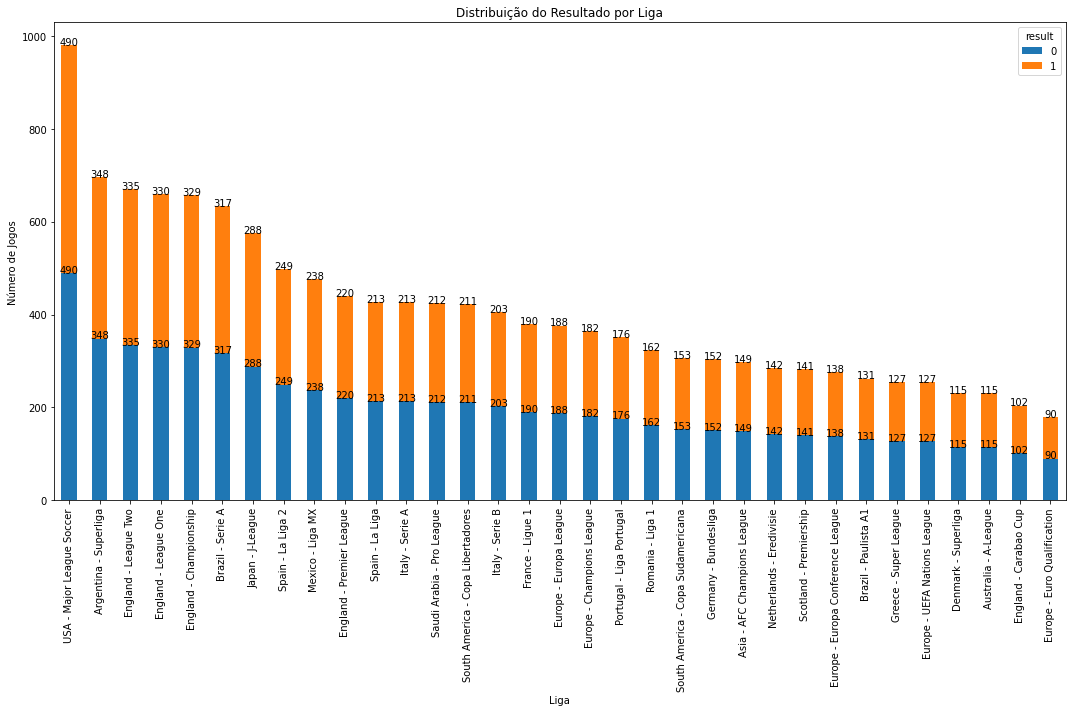

<Figure size 432x288 with 0 Axes>

In [105]:
# Função para filtrar ligas com base no número mínimo de partidas
def filter_leagues(df, league_col, matches, min_matches=100):
    # Agrupa o DataFrame por liga e conta o número único de partidas para cada liga
    league_game_counts = df.groupby(league_col)[matches].nunique()
    # Filtra para manter apenas as ligas com um número de partidas igual ou maior que min_matches
    leagues_filtered = league_game_counts[league_game_counts >= min_matches].index
    # Filtra o DataFrame original para incluir apenas linhas das ligas selecionadas
    filtered_data = df[df[league_col].isin(leagues_filtered)]
    return filtered_data

def balance_data(df, league_col='league', result_col='result'):
    leagues = df[league_col].unique()
    # Lista para armazenar os DataFrames balanceados para cada liga
    balanced_dfs = []

    # Cria uma cópia do DataFrame para não alterar a coluna 'minute' original
    df_copy = df.copy()

    # Itera sobre cada liga para balancear os dados
    for league in leagues:
        # Filtra o DataFrame para incluir apenas dados da liga atual
        league_df = df_copy[df_copy[league_col] == league]
        
        # Arredondando os minutos para o inteiro mais próximo para fins de balanceamento
        league_df['minute_rounded'] = league_df['minute'].round()

        # Selecionando os registros onde 'result' é 1
        result_1 = league_df[league_df[result_col] == 1]

        # Contando os minutos únicos arredondados e suas ocorrências em 'result' 1
        minutes_counts = result_1['minute_rounded'].value_counts()

        # Selecionando registros onde 'result' é 0 e amostrando aleatoriamente com base no número de ocorrências do mesmo minuto arredondado
        result_0_sample = pd.DataFrame()
        for minute, count in minutes_counts.items():
            # Filtra registros com 'result' 0 e o minuto arredondado correspondente
            potential_samples = league_df[(league_df['result'] == 0) & (league_df['minute_rounded'] == minute)]
            
            # Verifica se há registros suficientes para amostrar
            if potential_samples.shape[0] >= count:
                sample = potential_samples.sample(n=count, replace=True, random_state=42)
            else:
                # Se não houver registros suficientes, considera todos os registros disponíveis
                sample = potential_samples

            # Removendo a coluna 'minute_rounded' para manter o formato original de 'minute'
            sample = sample.drop(columns=['minute_rounded'])

            result_0_sample = pd.concat([result_0_sample, sample])

        # Combinando os dois conjuntos de dados para formar um novo dataframe balanceado
        balanced_dfs.append(pd.concat([result_1.drop(columns=['minute_rounded']), result_0_sample]))
    
    # Combina todos os DataFrames balanceados em um único DataFrame
    balanced_data = pd.concat(balanced_dfs).reset_index(drop=True)
    return balanced_data



print("Contando partidas por time...")
total_matches_per_team = len(df['match_id'].unique())
tota_leagues = len(df['league'].unique())
print("Total de ligas:", tota_leagues)
print("Total de partidas:", total_matches_per_team)

print("\nFiltrando dados de ligas...")
filtered_data = filter_leagues(df, 'league', 'match_id')
print("Dados filtrados:\n")
print(filtered_data['league'].value_counts())

print("\nBalanceando dados...")

balanced_data = balance_data(filtered_data)
# balanced_data = filtered_data.copy()

print("Dados balanceados:\n")
print(balanced_data['result'].value_counts())

league_distribution = balanced_data.groupby(['league', 'result']).size().unstack()
sorted_leagues = league_distribution.sum(axis=1).sort_values(ascending=False).head(100).index

print("Contando partidas depois dos filtros...")
total_matches_per_team = len(balanced_data['match_id'].unique())
tota_leagues = len(balanced_data['league'].unique())
print("Total de ligas:", tota_leagues)
print("Total de partidas:", total_matches_per_team)

plt.figure(figsize=(15, 10))
ax = league_distribution.loc[sorted_leagues].plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Distribuição do Resultado por Liga')
plt.ylabel('Número de Jogos')
plt.xlabel('Liga')
plt.tight_layout()
plt.xticks(rotation=90)

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.0f}', (x + width/2, y + height), ha='center')

plt.show()
plt.clf()  

In [106]:
balanced_data

,minute,homeTeam,awayTeam,goalHome,goalAway,shotsHome,shotsAway,blockedShotsHome,blockedShotsAway,league,...,fouls_home,fouls_away,offsides_home,offsides_away,tackles_home,tackles_away,result,match_id,possessiontime_away,possessiontime_home
0,16.32,Club Guaraní,CD San José,0.0,0.0,7.0,0.0,1.0,0.0,South America - Copa Libertadores,...,1.0,3.0,0.0,0.0,4.0,6.0,1,2020-01-29-Club Guaraní-CD San José,38.0,62.0
1,23.24,Club Universitario de Deportes,Carabobo FC,0.0,0.0,6.0,1.0,1.0,0.0,South America - Copa Libertadores,...,5.0,3.0,2.0,1.0,6.0,8.0,1,2020-01-29-Club Universitario de Deportes-Cara...,55.0,45.0
2,12.24,Barcelona SC,CA Progreso,0.0,0.0,1.0,2.0,0.0,0.0,South America - Copa Libertadores,...,2.0,3.0,0.0,0.0,0.0,4.0,1,2020-01-30-Barcelona SC-CA Progreso,49.0,51.0
3,28.19,Cerro Largo FC,CD Palestino,0.0,0.0,5.0,3.0,1.0,0.0,South America - Copa Libertadores,...,5.0,2.0,0.0,0.0,5.0,5.0,1,2020-02-05-Cerro Largo FC-CD Palestino,61.0,39.0
4,2.14,Deportivo Independiente Medellín,Deportivo Táchira FC,0.0,0.0,0.0,0.0,0.0,0.0,South America - Copa Libertadores,...,1.0,0.0,0.0,0.0,0.0,0.0,1,2020-02-05-Deportivo Independiente Medellín-De...,25.0,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13547,10.29,Spain,Cyprus,0.0,0.0,3.0,0.0,2.0,0.0,Europe - Euro Qualification,...,0.0,0.0,0.0,0.0,0.0,1.0,0,2023-09-12-Spain-Cyprus,19.0,81.0
13548,23.10,Ukraine,Italy,0.0,0.0,2.0,5.0,0.0,2.0,Europe - Euro Qualification,...,1.0,0.0,0.0,1.0,1.0,2.0,0,2023-11-20-Ukraine-Italy,62.0,38.0
13549,41.52,Spain,Scotland,0.0,0.0,7.0,0.0,2.0,0.0,Europe - Euro Qualification,...,3.0,4.0,2.0,1.0,3.0,5.0,0,2023-10-12-Spain-Scotland,23.0,77.0
13550,27.55,Romania,Kosovo,0.0,0.0,1.0,1.0,0.0,0.0,Europe - Euro Qualification,...,4.0,3.0,0.0,0.0,3.0,4.0,0,2023-09-12-Romania-Kosovo,29.0,71.0


In [107]:
# Ordenando o DataFrame
df.sort_values(by=['match_id', 'minute'], inplace=True)

In [108]:
balanced_data.reset_index(drop=True, inplace=True)
balanced_data.to_csv("data_balanced.csv", index=False, encoding='utf-8')

In [109]:
balanced_data.value_counts('result')

result
0    6776
1    6776
Name: count, dtype: int64

In [110]:
balanced_data

,minute,homeTeam,awayTeam,goalHome,goalAway,shotsHome,shotsAway,blockedShotsHome,blockedShotsAway,league,...,fouls_home,fouls_away,offsides_home,offsides_away,tackles_home,tackles_away,result,match_id,possessiontime_away,possessiontime_home
0,16.32,Club Guaraní,CD San José,0.0,0.0,7.0,0.0,1.0,0.0,South America - Copa Libertadores,...,1.0,3.0,0.0,0.0,4.0,6.0,1,2020-01-29-Club Guaraní-CD San José,38.0,62.0
1,23.24,Club Universitario de Deportes,Carabobo FC,0.0,0.0,6.0,1.0,1.0,0.0,South America - Copa Libertadores,...,5.0,3.0,2.0,1.0,6.0,8.0,1,2020-01-29-Club Universitario de Deportes-Cara...,55.0,45.0
2,12.24,Barcelona SC,CA Progreso,0.0,0.0,1.0,2.0,0.0,0.0,South America - Copa Libertadores,...,2.0,3.0,0.0,0.0,0.0,4.0,1,2020-01-30-Barcelona SC-CA Progreso,49.0,51.0
3,28.19,Cerro Largo FC,CD Palestino,0.0,0.0,5.0,3.0,1.0,0.0,South America - Copa Libertadores,...,5.0,2.0,0.0,0.0,5.0,5.0,1,2020-02-05-Cerro Largo FC-CD Palestino,61.0,39.0
4,2.14,Deportivo Independiente Medellín,Deportivo Táchira FC,0.0,0.0,0.0,0.0,0.0,0.0,South America - Copa Libertadores,...,1.0,0.0,0.0,0.0,0.0,0.0,1,2020-02-05-Deportivo Independiente Medellín-De...,25.0,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13547,10.29,Spain,Cyprus,0.0,0.0,3.0,0.0,2.0,0.0,Europe - Euro Qualification,...,0.0,0.0,0.0,0.0,0.0,1.0,0,2023-09-12-Spain-Cyprus,19.0,81.0
13548,23.10,Ukraine,Italy,0.0,0.0,2.0,5.0,0.0,2.0,Europe - Euro Qualification,...,1.0,0.0,0.0,1.0,1.0,2.0,0,2023-11-20-Ukraine-Italy,62.0,38.0
13549,41.52,Spain,Scotland,0.0,0.0,7.0,0.0,2.0,0.0,Europe - Euro Qualification,...,3.0,4.0,2.0,1.0,3.0,5.0,0,2023-10-12-Spain-Scotland,23.0,77.0
13550,27.55,Romania,Kosovo,0.0,0.0,1.0,1.0,0.0,0.0,Europe - Euro Qualification,...,4.0,3.0,0.0,0.0,3.0,4.0,0,2023-09-12-Romania-Kosovo,29.0,71.0
